# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2020-12-14 18:37:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.3’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2020-12-14 18:37:44 (60.7 MB/s) - ‘airline-passengers.csv.3’ saved [2180/2180]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
!pip install hydroeval
import hydroeval as he
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import check_array

ImportError: ignored

## Data Plot

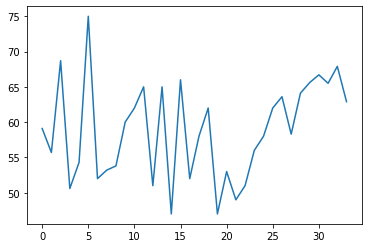

In [4]:
training_set = pd.read_csv('/content/drive/MyDrive/Final_caruid_csv/BARLEY_1100.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set.pop("Area")
training_set.pop("Year")
training_set = training_set.iloc[:,0:1].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [5]:
training_set

array([[59.1],
       [55.7],
       [68.7],
       [50.6],
       [54.3],
       [75. ],
       [52. ],
       [53.2],
       [53.8],
       [60. ],
       [62. ],
       [65. ],
       [51. ],
       [65. ],
       [47. ],
       [66. ],
       [52. ],
       [58. ],
       [62. ],
       [47. ],
       [53. ],
       [49. ],
       [51. ],
       [56. ],
       [58. ],
       [62. ],
       [63.6],
       [58.3],
       [64.1],
       [65.6],
       [66.7],
       [65.5],
       [67.9],
       [62.9]])

## Dataloading

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [7]:
training_data

array([[0.43214286],
       [0.31071429],
       [0.775     ],
       [0.12857143],
       [0.26071429],
       [1.        ],
       [0.17857143],
       [0.22142857],
       [0.24285714],
       [0.46428571],
       [0.53571429],
       [0.64285714],
       [0.14285714],
       [0.64285714],
       [0.        ],
       [0.67857143],
       [0.17857143],
       [0.39285714],
       [0.53571429],
       [0.        ],
       [0.21428571],
       [0.07142857],
       [0.14285714],
       [0.32142857],
       [0.39285714],
       [0.53571429],
       [0.59285714],
       [0.40357143],
       [0.61071429],
       [0.66428571],
       [0.70357143],
       [0.66071429],
       [0.74642857],
       [0.56785714]])

## Model

In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [9]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.16477
Epoch: 100, loss: 0.06657
Epoch: 200, loss: 0.06223
Epoch: 300, loss: 0.04581
Epoch: 400, loss: 0.02337
Epoch: 500, loss: 0.01444
Epoch: 600, loss: 0.01019
Epoch: 700, loss: 0.00693
Epoch: 800, loss: 0.00440
Epoch: 900, loss: 0.00345


## Testing for Airplane Passengers Dataset

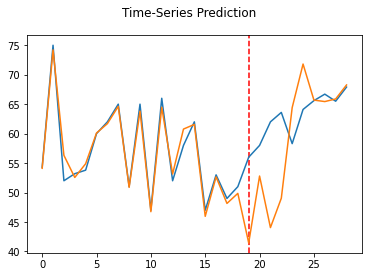

In [10]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [21]:

y_pred = []
for i in (data_predict):
  y_pred.append(i[0])

y_pred

[54.11334,
 74.2105,
 56.312237,
 52.564255,
 54.892506,
 60.102497,
 61.691486,
 64.625305,
 50.881233,
 63.82489,
 46.750584,
 64.480606,
 53.150978,
 60.77352,
 61.5618,
 45.96406,
 52.657394,
 48.154522,
 49.86045,
 41.45173,
 52.80181,
 44.054382,
 49.035328,
 64.41868,
 71.81035,
 65.69301,
 65.44132,
 65.882164,
 68.25815]

In [25]:
dataY_plot
y_true = []
for i in (dataY_plot):
  y_true.append(i[0])

y_true

[54.300003,
 75.0,
 52.0,
 53.2,
 53.8,
 60.0,
 61.999996,
 65.0,
 51.0,
 65.0,
 47.0,
 66.0,
 52.0,
 58.0,
 61.999996,
 47.0,
 53.0,
 49.0,
 51.0,
 56.0,
 58.0,
 61.999996,
 63.6,
 58.3,
 64.1,
 65.6,
 66.7,
 65.5,
 67.9]

In [50]:
diff = []
for i in range(1,len(y_true)):
  diff.append(y_true[i] - y_pred[i])

diff

[0.7894974,
 -4.312237,
 0.635746,
 -1.0925064,
 -0.1024971,
 0.30850983,
 0.37469482,
 0.118766785,
 1.1751099,
 0.24941635,
 1.5193939,
 -1.1509781,
 -2.7735214,
 0.4381981,
 1.0359383,
 0.3426056,
 0.84547806,
 1.1395493,
 14.548271,
 5.198189,
 17.945614,
 14.564671,
 -6.118679,
 -7.71035,
 -0.09300995,
 1.2586746,
 -0.382164,
 -0.35814667]

In [33]:
r2_score(y_true,y_pred)

0.3595157714416224

In [48]:

def mean_absolute_percentage_error(y_t, y_p): 
    
    return np.mean(np.abs((y_t - y_p) / y_t)) * 100
mean_absolute_percentage_error(dataY_plot,data_predict)

5.0343383103609085

In [52]:
nse = he.evaluator(he.nse, y_pred, y_true)
nse

array([0.35951577])